In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../code/")
from vae import *
from util import *
from keras.callbacks import ModelCheckpoint

## import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
np.random.seed(777);

## simulate discrete label data

In [ ]:
length = 10000; ##num datapoint
n_cls = 5; ##num label
n_dim = 100;## num dimension
z_true, u_true, mean_true, lam_true = simulate_data(length, n_cls, n_dim); ##latent, disc labels, lambda for poisson distr
x_true = np.random.poisson(lam_true);
np.savez('path', u=u_true, z=z_true, x=x_true, lam=lam_true, mean=mean_true);

## simulate continuous label data

In [ ]:
length = 15000;
n_dim = 100;
z_true, u_true, mean_true, lam_true = simulate_cont_data_diff_var(length, n_dim);
x_true = np.random.poisson(lam_true);
np.savez('path', u=u_true, z=z_true, x=x_true, lam=lam_true, mean=mean_true);

## load continuous label simulated data

In [11]:
## load data
dat = np.load('path');
u_true = dat['u'];
z_true = dat['z'];
x_true = dat['x'];

In [12]:
## reshape data
x_all = x_true.reshape(50,300,-1);
cu_all = u_true.reshape(50,300,-1);
u_all = np.zeros(cu_all.shape);

##split test, validation and train
x_train = x_all[:40];
u_train = u_all[:40];
cu_train = cu_all[:40];

x_valid = x_all[40:45];
u_valid = u_all[40:45];
cu_valid = cu_all[40:45];

x_test = x_all[45:];
u_test = u_all[45:];
cu_test = cu_all[45:];

## fit vae

In [14]:
## fit model
vae = vae_mdl(dim_x=x_all[0].shape[-1], 
                   dim_z=2,
                   gen_nodes=60, n_blk=2, mdl='poisson', learning_rate=5e-4);

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          19688       ['input_10[0][0]',               
                                 (None, 2),                       'input_12[0][0]']               
                                 (None, 2),                                                       
                                 (None, 2),                                                     

/Users/yixinzhang/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model_chk_path = '../results/sim_cont_nflow_2d_777_vae.h5' ##save model
mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
s_n = vae.fit(custom_data_generator(x_train, u_train),
              steps_per_epoch=len(x_train), epochs=1000,
              verbose=1,
              validation_data = custom_data_generator(x_valid, u_valid),
              validation_steps = len(x_valid), callbacks=[mcp]);

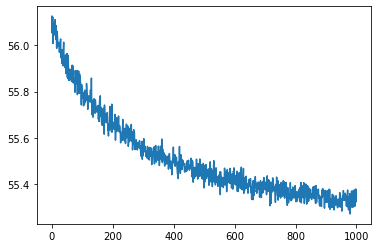

In [18]:
plt.plot(s_n.history['val_loss'][:])

In [19]:
model_chk_path = '../results/sim_cont_nflow_2d_777_vae.h5'
vae.load_weights(model_chk_path);

In [20]:
outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
# post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var

<ipython-input-20-e39217881d67>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  outputs = vae.predict_generator(custom_data_generator(x_all, u_all),


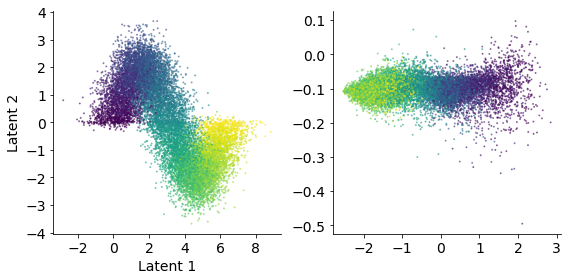

In [22]:
length = 30;
ll = 15000;
c_vec = plt.cm.viridis(np.linspace(0,1,length))
bins = np.linspace(0,2*np.pi,length);
centers = (bins[1:]+bins[:-1])/2;
disc_loc = np.digitize(u_true[:,0],centers);
c_all = c_vec[disc_loc];

fsz = 14;

plt.figure(figsize=(8,4));
ax1 = plt.subplot(1,2,1)
plt.scatter(z_true[:ll,0], z_true[:ll,1], c=c_all, s=1,alpha=0.5);
ax1.set_xlabel('Latent 1',fontsize=fsz,fontweight='normal');
ax1.set_ylabel('Latent 2',fontsize=fsz,fontweight='normal');
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.setp(ax1.get_xticklabels(), fontsize=fsz);
plt.setp(ax1.get_yticklabels(), fontsize=fsz);

ax2 = plt.subplot(1,2,2)
plt.scatter(outputs[0][:ll,1], outputs[0][:ll,0], c=c_all, s=1,alpha=0.5);
#ax2.set_xlabel('Latent 1',fontsize=fsz,fontweight='normal');
#ax2.set_ylabel('Latent 2',fontsize=fsz,fontweight='normal');
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.setp(ax2.get_xticklabels(), fontsize=fsz);
plt.setp(ax2.get_yticklabels(), fontsize=fsz);

plt.tight_layout();

# temporal data

In [ ]:
##simulation function (similar to cont simulation with differnt var)
def simulate_temporal_data(length, seq_len, n_dim):
    """
    Simulates temporal data with a continuous label affecting the sequence pattern.

    Argumentss:
    length (int): Number of sequences to generate
    seq_len (int): Length of each temporal sequence
    n_dim (int): Number of features at each time step in the sequence

    Returns:
    z_true (np.array): latent variables
    u_true (np.array): continuous labels
    mean_true (np.array):  means of the sequences
    lam_true (np.array): lambda for Poisson distr
    """
    np.random.seed(777);

    ## simulate continuous label for time
    u_true = np.random.uniform(0, 2 * np.pi, size=[length, 1]);

    ## simulate latent variables depending on time
    z_true = np.zeros((length, seq_len, n_dim));
    for i in range(length):
        for t in range(seq_len):
            mu_t = np.sin(u_true[i] + (t / seq_len) * 2 * np.pi);
            z_true[i, t, :] = np.random.normal(mu_t, 0.1, n_dim);

    # RealNVP model for transformation
    x_input = layers.Input(shape=(seq_len, n_dim));
    x_output = realnvp_block(x_input);
    for ii in range(n_blk-1):
        x_output = Lambda(perm_func, arguments={'ind':permute_ind[ii]})(x_output);
        x_output = realnvp_block(x_output);
    
    realnvp_model = Model(inputs=[x_input], outputs=x_output);
    mean_true = realnvp_model.predict(z_true)
    lam_true = np.exp(2.2*np.tanh(mean_true));

    return z_true, u_true, mean_true, lam_true
